# Least squares regression

Philipp Schlatter, LSTM FAU, 2024

In [127]:
%%html
<style>
div.jupyter-widgets.widget-label {display: none;}
</style>

In [184]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from numpy.linalg import norm
import math as mt
from scipy import special
from scipy import stats
from scipy.stats import chi2,t

π = mt.pi

params = {'legend.fontsize': 10,
          'legend.loc':'best',
          'figure.figsize': (6,4),
          'lines.markerfacecolor':'none',
          'axes.labelsize': 12,
          'axes.titlesize': 12,
          'xtick.labelsize':10,
          'ytick.labelsize':10,
          'grid.alpha':0.6}
pylab.rcParams.update(params)

Generate some data

In [245]:
x = np.linspace(0,4,20)
xx = np.linspace(-1,5,100)
y = np.array([-1, 0.2, 0.9, 2.1])

uniform_noise = 0.001

y = 0.8*x+2*np.sin(x)+uniform_noise*np.random.rand(np.size(x))

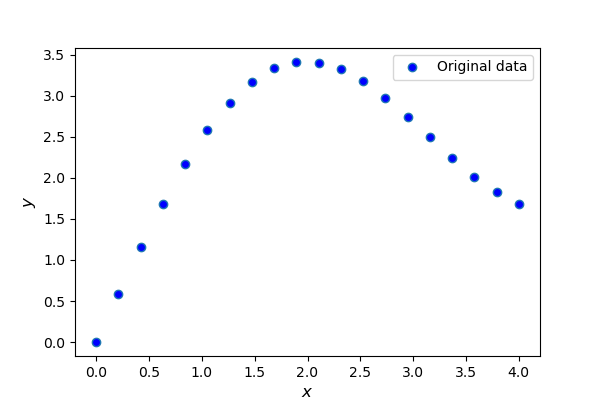

In [246]:
fig=plt.figure()
fig.canvas.header_visible = False
plt.plot(x, y, 'o', label='Original data', markersize=6,markerfacecolor='b')
plt.xlabel(r'$x$'); plt.ylabel(r'$y$')
plt.legend()
plt.show()

## 1. Linear least squares regression

### 1.1. Linear function

To start, let's try to fit a straight line to a set of points $\{x_i, y_i\}$, i.e. $\hat{y} = m x + b$ with the slope $m$ and the intercept $b$. The intuitive way is by computing the slope $m$ as the correlation between $x_i$ and $y_i$, and normalising by the corresponding standard deviations $\mathrm{std}(y_i)$ and $\mathrm{std}(x_i)$. The intercept can then be computed by the mean values in $x$ and $y$.

In [247]:
m1=np.corrcoef(x,y)[0,1]*np.std(y)/np.std(x)
c1 = np.mean(y)-m1*np.mean(x)
c1,m1

(1.7825332651612462, 0.2813447813945427)

The same result can also be found by classical least squares. Assume that the line follows the following relation,
$$y = A p$$
with $p=[c,m]^\top$ and $A=[1^\top,x_i^\top]$. The resulting values for $c$ and $m$ can then be found by the numpy function `lstsq`:

In [248]:
A = np.vstack([np.ones(len(x)),x]).T

In [249]:
a1,a2 = np.linalg.lstsq(A, y,rcond=-1)[0]
a1,a2

(1.7825332651612447, 0.2813447813945429)

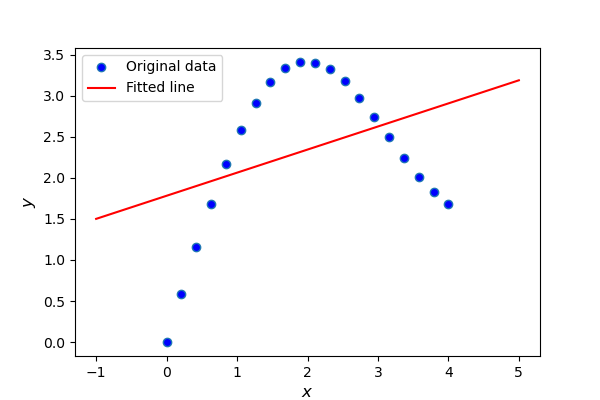

In [250]:
plt.figure()
plt.plot(x, y, 'o', label='Original data',markersize=6,markerfacecolor='b')
plt.plot(xx, a1+a2*xx, 'r', label='Fitted line')
plt.xlabel(r'$x$'); plt.ylabel(r'$y$')
plt.legend()
plt.show()

The values for $a_j$ correspond to the minimum of the objective function 
$$H=\sum_{i=1}{N} \left[ a_0 f_0(x_i) + a_1 f_1(x_i) + \ldots \right]^2$$

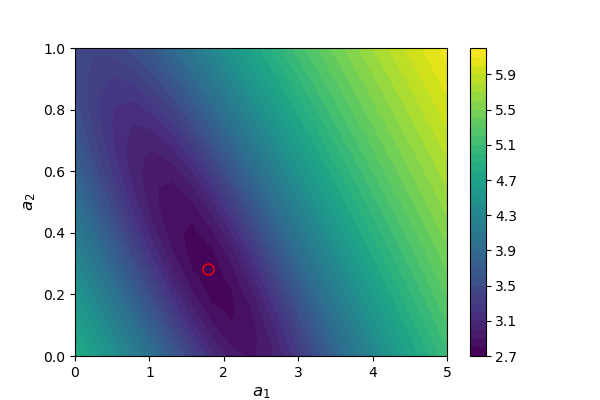

In [251]:
N_a1=21
N_a2=20
A1,A2 = np.meshgrid(np.linspace(0,5,N_a2),np.linspace(0,1,N_a1))

H=np.zeros((N_a1,N_a2))
N= y.size

for ii in range(N_a2):
    for jj in range(N_a1):
        a1N=A1[jj,ii]
        a2N=A2[jj,ii]
        for k in range(N):
            H[jj,ii] += (a1N+a2N*x[k] - y[k])**2
            
fig=plt.figure()
fig.canvas.header_visible = False
CS=plt.contourf(A1[0,:],A2[:,0],np.log(H),levels=40)
plt.ylabel(r'$a_2$')
plt.xlabel(r'$a_1$')
plt.colorbar()
plt.plot(a1,a2,'ro',ms=8)
plt.show()

### 1.2. Arbitrary functions for linear regression

In a similar way, even more complex linear regression can be constructed, here for instance as a combination of 
$$ \hat{y} = a_1 + a_2 x + a_3 x^2 + a_4 \sin(x) \ . $$
Note that this is still linear regression as the coefficients are prefactors.

In [252]:
A = np.vstack([np.ones(len(x)),x,x**2,np.sin(x)]).T

In [253]:
a1,a2,a3,a4 = np.linalg.lstsq(A, y,rcond=-1)[0]
a1,a2,a3,a4

(0.0006855573305801598,
 0.8017846024480909,
 -0.0005661595029568999,
 1.998199964966002)

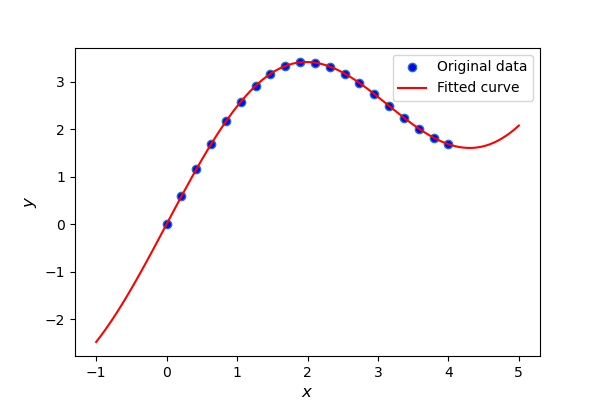

In [254]:
plt.figure()
plt.plot(x, y, 'o', label='Original data', markersize=6,markerfacecolor='b')
plt.plot(xx, a1+a2*xx+a3*xx**2+a4*np.sin(xx), 'r', label='Fitted curve')
plt.legend()
plt.xlabel(r'$x$'); plt.ylabel(r'$y$')
plt.show()

The estimation of the error $\varepsilon=\hat{y}-y_i$ (i.e. its standard deviation) can be computed using `std`, subtracting two degrees of freedom (Bessel correction). For a uniform distribution, the standard deviation is $\sqrt{1/12}\approx 0.289$.

In [273]:
err = y-(a1+a2*x+a3*x**2+a4*np.sin(x))
std = np.std(err,ddof=-2)
std, uniform_noise*np.sqrt(1/12)

(0.00019326030129357267, 0.0002886751345948129)

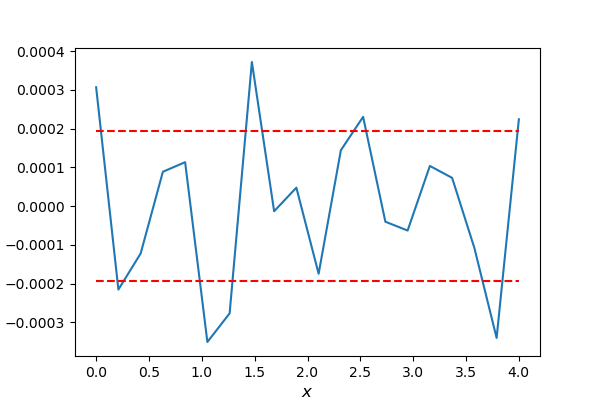

In [274]:
plt.figure()
plt.plot(x,y-(a1+a2*x+a3*x**2+a4*np.sin(x)))
plt.plot(x,x*0+std,'r--')
plt.plot(x,x*0-std,'r--')
plt.xlabel(r'$x$'); plt.ylabel(r'$\varepsilon$')
plt.show()

### 1.3. Alternative ways of computing the coefficients 

The expansion coefficients $a_j$ can be computed in an equivalent way using singular value decomposition (SVD), by the pseudoinverse or simply by matrix multiplications.

In [120]:
U, S, Vh =np.linalg.svd(A,full_matrices=False)
Apinv = Vh.T@np.diag(1/S)@U.T
Apinv.dot(y)

array([ 0.58989773, -0.99833677,  0.61119623,  3.68777269])

In [121]:
Ap = np.linalg.pinv(A)     # Ap = np.linalg.inv(A.T@A)@A.T
Ap@y

array([ 0.58989773, -0.99833677,  0.61119623,  3.68777269])

In [122]:
np.linalg.inv(A.T@A)@A.T@y

array([ 0.58989773, -0.99833677,  0.61119623,  3.68777269])

### 1.4. Uncertainty analysis

array([[ 3.95259691e-01,  3.21921681e-01,  2.47123571e-01,
         1.74392842e-01,  1.06938243e-01,  4.75081059e-02,
        -1.73101719e-03, -3.92900257e-02, -6.44230246e-02,
        -7.71602619e-02, -7.83067931e-02, -6.94069313e-02,
        -5.26760541e-02, -3.09027768e-02, -7.32581343e-03,
         1.45090382e-02,  3.09054714e-02,  3.81798914e-02,
         3.28240754e-02,  1.16600879e-02],
       [ 6.08525189e-02,  1.50006566e-01,  9.18611362e-02,
        -5.28153015e-02, -2.28745058e-01, -3.88582169e-01,
        -4.95003095e-01, -5.22354844e-01, -4.57787759e-01,
        -3.01822928e-01, -6.83291741e-02,  2.16089361e-01,
         5.13268000e-01,  7.75166801e-01,  9.45991900e-01,
         9.64659247e-01,  7.67491950e-01,  2.91032109e-01,
        -5.25157016e-01, -1.73582225e+00],
       [-5.81045338e-02, -7.79605029e-02, -5.25679868e-02,
        -8.55034746e-04,  5.99605622e-02,  1.15131572e-01,
         1.53032528e-01,  1.65673084e-01,  1.49050854e-01,
         1.03328144e-01,  3.2

In [270]:
np.std(err,ddof=-2)

0.00019326030129357267

In [271]:
np.std(err,ddof=0)

0.0002026931139967284